# Rating Based Recommendation

### Importing packages and data

In [2]:
import numpy as np
import pandas as pd
import sklearn
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import random
sns.set_style('whitegrid')
#matplotlib inline

In [3]:
#ratings = pd.read_csv (r'./../data/ratings.csv')
ratings_small = pd.read_csv (r'./../data/ratings_small.csv')
credits = pd.read_csv (r'./../data/credits.csv')
keywords = pd.read_csv (r'./../data/keywords.csv')
links = pd.read_csv (r'./../data/links.csv')
links_small = pd.read_csv (r'./../data/links_small.csv')
movies_metadata = pd.read_csv (r'./../data/movies_metadata.csv')

c:\python39\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Viewing data

In [4]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
ratings_small.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### Creating table with movieId total count of ratings for each movie id

In [7]:
rating_info = pd.DataFrame(ratings_small.groupby('movieId')['rating'].mean())
rating_info['count'] = pd.DataFrame(ratings_small.groupby('movieId')['rating'].count())
rating_info.head()

,rating,count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


### Analyzing data by viewing graphs
checking if suitable for correlation

<AxesSubplot:>

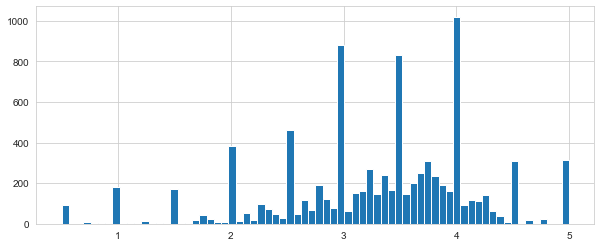

In [8]:
plt.figure(figsize=(10,4))
rating_info['rating'].hist(bins=70)

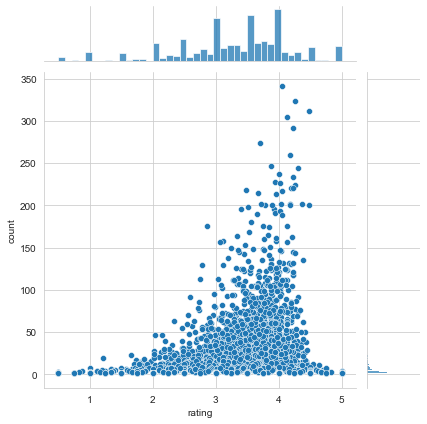

In [9]:
sns.jointplot(x='rating', y='count', data=rating_info)

Ratings are rudimentarily normally distributed 
* therefore correlation is applicable

### Creating pivot table with ratings for each movie from each user

In [10]:
rating_pivot = pd.pivot_table(ratings_small, index='userId', columns='movieId', values='rating')
rating_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Actual recommendation algorithm

In [11]:
def recommendation(movie_id):
    #calculating correlation to other users
    correlation = rating_pivot.corrwith(rating_pivot[movie_id])
    #creating table
    corr_movie = pd.DataFrame(correlation, columns=['correlation'])
    #dropping movies non values => no correlation
    corr_movie.dropna(inplace=True)
    #adding total count of ratings for each movie to the table
    corr_movie = corr_movie.join(rating_info['count'])
    #listing movies by correlation score and just using movies with more then the 90th percentile of the total count of ratings per movie
    cutoff = rating_info['count'].quantile(0.90)
    corr_movie = corr_movie[corr_movie['count']>cutoff].sort_values('correlation', ascending=False)
    #deleting movie that the recommendation is based on from recommendation list
    if movie_id in corr_movie.index:
        corr_movie = corr_movie.drop([movie_id])
    #changing index to ranking and movieId to column
    corr_movie['movieId'] = corr_movie.index
    corr_movie = corr_movie.set_index(pd.Index(list(range(len(corr_movie)))))
    return corr_movie

In [12]:
movie_ids = [2, 5, 546]
rec_movies = []
for i in movie_ids:
    #a.iloc[1].array[0]
    a = recommendation(i)
    #adding top 5 recommended movies to array 
    for k in range(5):
        rec_movies.append(int(a.iloc[k].array[2]))
    #counting top recommended movies
    rec_count = collections.Counter(rec_movies)
    rec_final = sorted(rec_count, key=rec_count.get, reverse=True)[:4]
print(rec_final)

c:\python39\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\python39\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\python39\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\python39\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\python39\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\python39\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


[73017, 77561, 44195, 1093]


In [13]:
movies_id = movies_metadata.loc[:,'id'].array
#choosing 10 random movieIds from collection
random_ids = []
for i in range(10):
    random_ids.append(random.choice(movies_metadata.loc[:,'id'].array))
movie_selection = []
for i in random_ids:
    movie_selection.append(movies_metadata.loc[movies_metadata['id'] == str(i), 'original_title'].array[0])
print(movie_selection)

['Der Knochenmann', 'Paradise Now', 'La estrategia del caracol', 'Deliverance Creek', 'Brute Force', 'Stealing Time', 'The Edge of Dreaming', '恐怖份子', 'Vivi o, preferibilmente, morti', 'Incubus']


### Testing for web app stuff...

In [14]:
rec_names = []
for i in rec_movies:
    rec_names.append(movies_metadata.loc[movies_metadata['id'] == str(i)]['original_title'].array[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [15]:
print(movies_metadata['id'].loc[0])
print(movies_metadata['original_title'].loc[0])
print(movies_metadata.loc[movies_metadata['id'] == str(862), 'release_date'].array[0])

862
Toy Story
1995-10-30
